In [1]:
%matplotlib inline

In [2]:
import glob
import json
import re
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yaml
import networkx as nx

from IPython.display import HTML, display_html

from aggregatedata import construct_posts, construct_tags

In [3]:
# utils
def html(content):
    display_html(HTML(content))

# Data ingest

This pulls data from the posts themselves, as well as from Google Analytics snapshots that I've taken. It attempts to aggregate as much as possible in the `posts` variable:

In [4]:
posts = construct_posts()

In [5]:
tags = construct_tags(posts)

# Some analyses

Here are a handful of analyses based upon some questions I had during the past year.

## Which posts did people read the most?

Let's see a list of top ten posts, by pageview (GA):

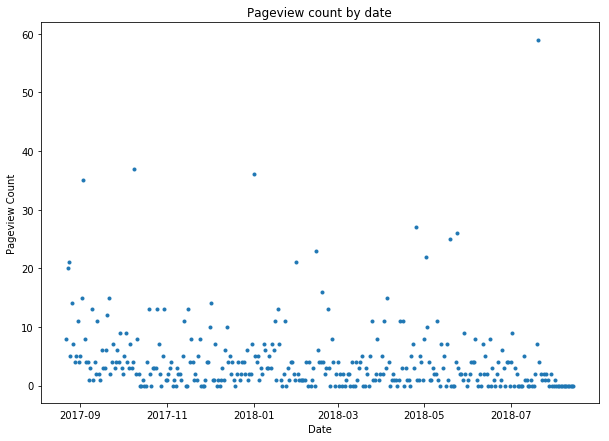

In [6]:
plt.figure(figsize=(10, 7))
plt.plot(posts.date, posts.Pageviews, '.')
plt.ylabel("Pageview Count")
plt.xlabel("Date")
plt.title("Pageview count by date")
plt.show()

In [7]:
posts.sort_values('Pageviews', ascending=False).head(10)[
        ['Pageviews', 'title', 'byline', 'date', 'href']
    ]

,Pageviews,title,byline,date,href
index,,,,,
334,59.0,Sampling Neuron Morphologies,Farhoodi & Körding,2018-07-20,https://blog.jordan.matelsky.com/365papers/334
49,37.0,Structural and functional diversity of a dense...,Bae et al,2017-10-09,https://blog.jordan.matelsky.com/365papers/49
134,36.0,Content-Aware Image Restoration: Pushing the L...,Weigert et al,2018-01-01,https://blog.jordan.matelsky.com/365papers/134
13,35.0,Gaze-stabilizing central vestibular neurons pr...,Schoppik et al,2017-09-03,https://blog.jordan.matelsky.com/365papers/13
248,27.0,MuseGAN: Multi-track Sequential Generative Adv...,Dong & Hsiao et al,2018-04-25,https://blog.jordan.matelsky.com/365papers/248
277,26.0,The Roles of Supervised Machine Learning in Sy...,"Glaser, Benjamin, Farhoodi & Kording",2018-05-24,https://blog.jordan.matelsky.com/365papers/277
272,25.0,Exploring the Color of Glass: Letters of Recom...,Trix & Psenka,2018-05-19,https://blog.jordan.matelsky.com/365papers/272
178,23.0,Diurnal transcriptome atlas of a primate acros...,Mure et al,2018-02-14,https://blog.jordan.matelsky.com/365papers/178
255,22.0,"Spontaneous behaviors drive multidimensional, ...",Stringer & Pachitariu et al,2018-05-02,https://blog.jordan.matelsky.com/365papers/255


## What did I write most about?

Let's look at a list of the most-used tags — and a list of the most-viewed tags.

In [8]:
_html = "<h3>Most written-about tags</h3>"
for i, row in tags.sort_values('usecount', ascending=False).head(10)[
    ['text', 'usecount']
].iterrows():
    _html += "<b>{}</b>: {} posts, ".format(row.text, int(row.usecount))

html(_html)

_html = "<h3>Most read-about tags</h3>"
for i, row in tags.sort_values('viewcount', ascending=False).head(10)[
    ['text', 'viewcount']
].iterrows():
    _html += "<b>{}</b>: {} views, ".format(row.text, int(row.viewcount))

html(_html)

Most written-about tags neuroscience : 103 posts, neural-network : 77 posts, machine-learning : 51 posts, computer-vision : 26 posts, deep-learning : 26 posts, graphs : 25 posts, vision : 23 posts, 3D : 22 posts, behavior : 20 posts, CNN : 19 posts,

Most read-about tags connectomics : 0 views, GRU : 0 views, genitals : 0 views, blastopore : 0 views, gut : 0 views, evolutionary-development : 0 views, anus : 0 views, phylogenetics : 0 views, bilateria : 0 views, flyEM : 0 views,

In [9]:
tags['interest_index'] = tags['viewcount'] / tags['usecount']

## Surprisingly interesting tags, and surprisingly uninteresting tags

It's hard to understand the above numbers because I wrote about some topics (e.g. neuroscience) a lot, and so, understandably, their pageview counts are amplified. But if we normalize and try to get an "interest index" — an indication of tags for which public interest was proportionally greater than how much I wrote about them — then the data tell a different story.

The formula is simply $\frac{views}{usage}$, or the number of times a tag was viewed on _all_ of its posts, versus the number of times I posted about it.

Here are a list of tags about which I wrote very little — but each tag had very high pageview counts.

And, conversely, a separate list of tags for which, given the amount I wrote about them, I would have expected more pageviews. (I omit tags with zero pageviews here, since that's not a useful story!)

In [12]:
_html = """
<h3>Surprisingly most interesting tags</h3>
"""
for i, row in tags.sort_values('interest_index', ascending=False).head(10)[
    ['text', 'interest_index']
].iterrows():
    _html += "<b>{}</b>: {}, ".format(row.text, row.interest_index)

html(_html)

_html = """
<h3>Surprisingly least interesting tags</h3>
"""
for i, row in tags[tags.interest_index > 0].sort_values('interest_index', ascending=False).tail(10)[
    ['text', 'interest_index']
].iterrows():
    _html += "<b>{}</b>: {}, ".format(row.text, row.interest_index)

html(_html)

Surprisingly most interesting tags 
 connectomics : 0.0, GRU : 0.0, genitals : 0.0, blastopore : 0.0, gut : 0.0, evolutionary-development : 0.0, anus : 0.0, phylogenetics : 0.0, bilateria : 0.0, flyEM : 0.0,

Surprisingly least interesting tags

# The tag graph

Here, I converted the list of tags into a graph, where nodes are tags and undirected weighted edges are shared papers. So the edge $(neuroscience, retina)$ with $w=5$ means that the tag `neuroscience` appears in the same post as `retina` five times.

As it turns out, this graph is pretty big and very dense, and so it doesn't render nicely. I export it in another notebook for visualization; otherwise, unfortunately, the full graph is basically unviewable.

In [86]:
sorted_tags = sorted(tags.index)

tag_coocurrence = np.zeros((len(sorted_tags), len(sorted_tags)))

for i, post in posts.iterrows():
    for tagA in post.tags:
        for tagB in post.tags:
            if tagA == tagB: continue
            tag_coocurrence[sorted_tags.index(tagA), sorted_tags.index(tagB)] += 1

G = nx.from_numpy_matrix(tag_coocurrence)
G = nx.relabel_nodes(G, lambda x: sorted_tags[x])

In [92]:
G_most = nx.Graph([(u,v,d) for u,v,d in G.edges(data=True) if d['weight']>3])
print(len(G_most))

79


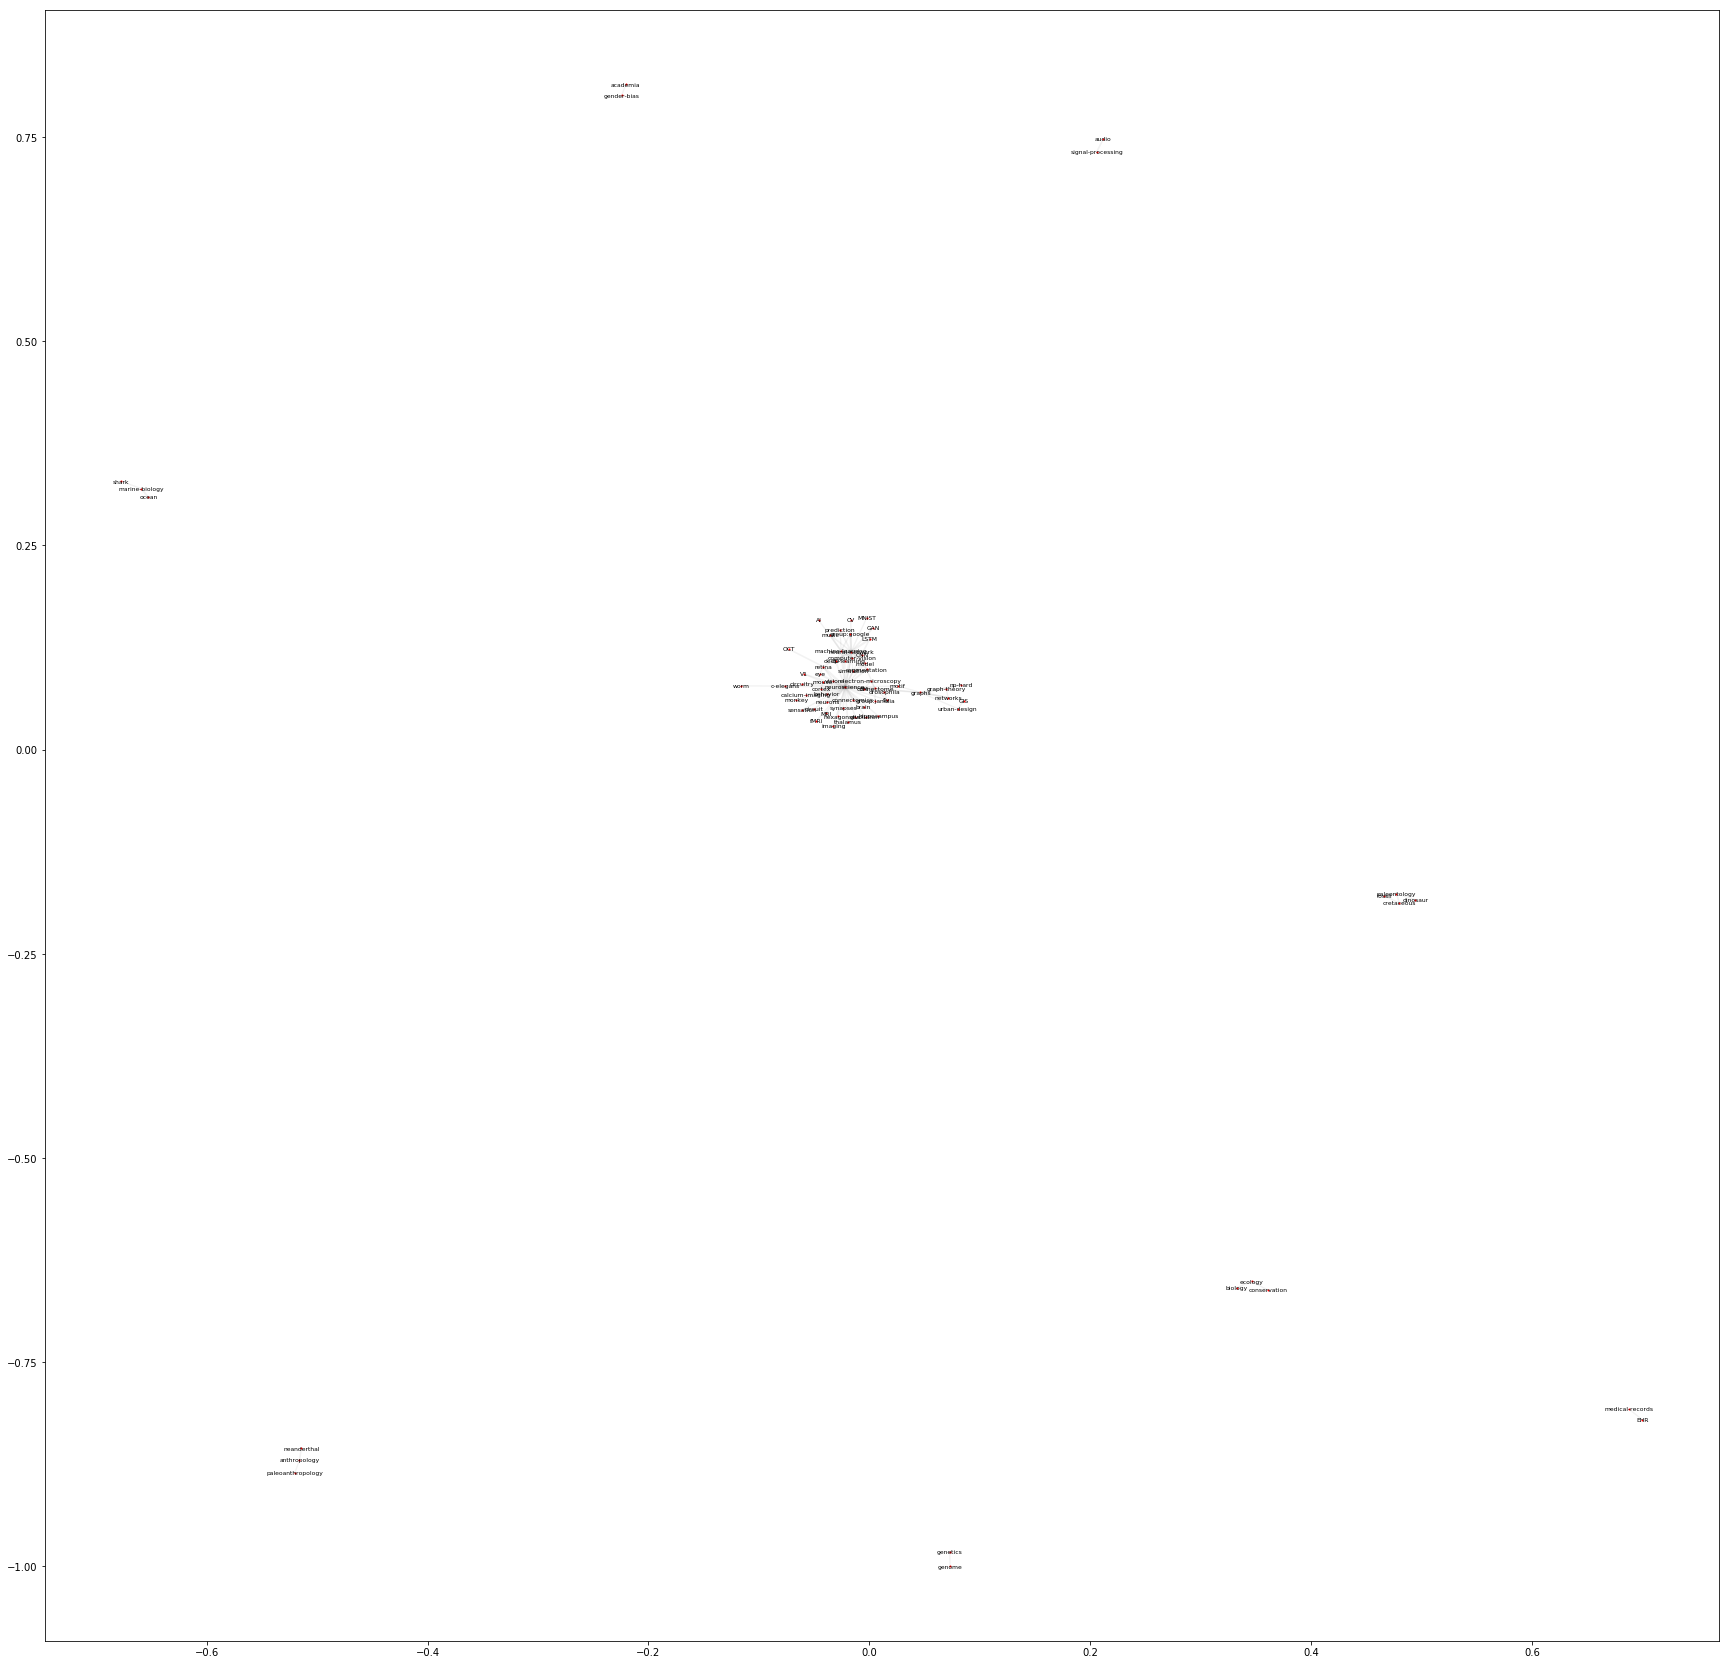

In [93]:
plt.figure(figsize=(30, 30))
pos = nx.layout.spring_layout(G_most, k=0.1, iterations=100)
nx.draw_networkx_nodes(G_most, pos=pos, node_size=1)
nx.draw_networkx_edges(G_most, pos=pos, width=[np.log(attr['weight']) for _, _, attr in G_most.edges(data=True)], alpha=0.05)
nx.draw_networkx_labels(G_most, pos=pos, font_size=6)
plt.show()

In [94]:
nx.write_gexf(G, '/Users/mateljk1/365tags.gexf')

## Tags most commonly seen together

In [45]:
sorted(tags.index)

['1930s',
 '2D',
 '2p',
 '3D',
 '3D-printing',
 '3D-reconstruction',
 'A1',
 'AAV',
 'AI',
 'APG',
 'ARC',
 'Alaska',
 'Apache-Spark',
 'Australia',
 'BCI',
 'BWT',
 'BabylonAI',
 'Bragg-peaks',
 'Brazil',
 'Buen-formation',
 'CA1',
 'CAD',
 'CLSM',
 'CNN',
 'CNO',
 'CNT',
 'CO2',
 'CT-scan',
 'CTC',
 'CUBIC',
 'CV',
 'CaMKII',
 'Cambrian',
 'Canada',
 'Cantwell-formation',
 'CelebA',
 'CorrNet',
 'DNA',
 'DNN',
 'DREADD',
 'DRM',
 'DSRM',
 'DeepScores',
 'Denali',
 'Devonian',
 'Disney',
 'ECoG',
 'EEG',
 'EHR',
 'EM',
 'Egypt',
 'EyePACS',
 'FCN',
 'FFN',
 'FHIR',
 'Flesch-Kincaid',
 'GABA',
 'GAN',
 'GCaMP6',
 'GIS',
 'GPS',
 'GPU',
 'GRU',
 'Gobi',
 'Gogo-formation',
 'Gulf-of-Mexico',
 'HL7',
 'HTR',
 'Hox',
 'Hubble',
 'ISBI-2012',
 'IUCN',
 'Ig-Nobel',
 'ImageNet',
 'India',
 'IoT',
 'Kapton',
 'LAS',
 'LGN',
 'LIAF',
 'LM',
 'LSTM',
 'Lakh-MIDI',
 'Levitron',
 'Libya',
 'M1',
 'MAPseq',
 'MEC',
 'MEG',
 'MFI',
 'MIDI',
 'MLF',
 'MNIST',
 'MPA',
 'MRI',
 'MUSCIMA++',
 'Markov',
